<a href="https://colab.research.google.com/github/Redcoder815/Machine_Learning/blob/main/RandomForestRegressorFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

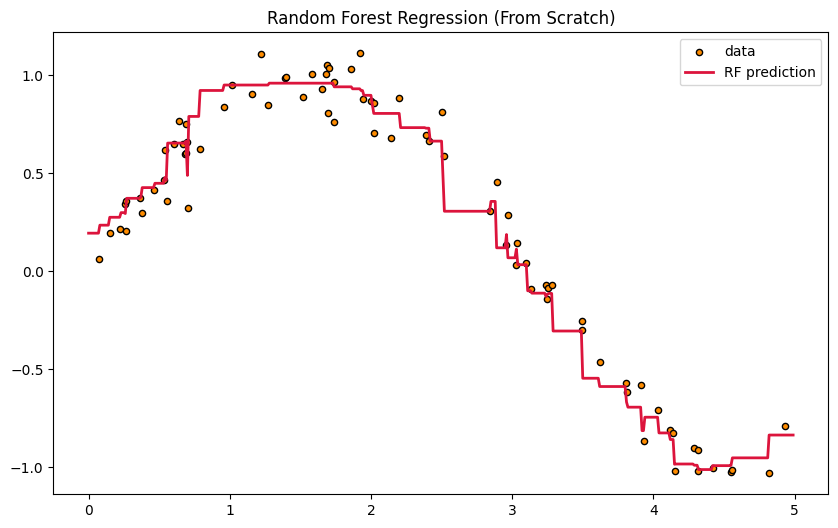

In [15]:
import numpy as  np
import matplotlib.pyplot as plt

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeRegressorScratch:
    def __init__(self, max_depth=5, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features # New parameter for Random Forest
        self.root = None

    def fit(self, X, y):
        # If n_features is None, use all features (default DT behavior)
        self.n_features = X.shape[1] if self.n_features is None else min(X.shape[1], self.n_features)
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return Node(value=np.mean(y))

        # Randomly select feature indices for this split
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        best_feat, best_thresh = self._best_split(X, y, feat_idxs)
        if best_feat is None:
            return Node(value=np.mean(y))

        left_idx = X[:, best_feat] <= best_thresh
        right_idx = ~left_idx
        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], y[right_idx], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_mse = float('inf')
        split_feat, split_thresh = None, None

        for feat in feat_idxs:
            thresholds = np.unique(X[:, feat])
            for thresh in thresholds:
                left_y = y[X[:, feat] <= thresh]
                right_y = y[X[:, feat] > thresh]

                if len(left_y) > 0 and len(right_y) > 0:
                    mse = self._calculate_mse(left_y, right_y)
                    if mse < best_mse:
                        best_mse, split_feat, split_thresh = mse, feat, thresh
        return split_feat, split_thresh

    def _calculate_mse(self, left_y, right_y):
        n = len(left_y) + len(right_y)
        mse_l = np.var(left_y) * len(left_y)
        mse_r = np.var(right_y) * len(right_y)
        return (mse_l + mse_r) / n

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None: return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


class RandomForestRegressorScratch:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            # 1. Bootstrapping: Sample indices with replacement
            n_samples = X.shape[0]
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]

            # 2. Train a tree on the bootstrap sample
            tree = DecisionTreeRegressorScratch(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                n_features=self.n_features
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Collect predictions from every tree
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Average the predictions (Aggregating)
        return np.mean(tree_preds, axis=0)

# --- Testing the Random Forest ---

# Generate synthetic data
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])

# Train Random Forest
rf = RandomForestRegressorScratch(n_trees=10, max_depth=5)
rf.fit(X, y)

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_pred = rf.predict(X_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_pred, color="crimson", label="RF prediction", linewidth=2)
plt.title("Random Forest Regression (From Scratch)")
plt.legend()
plt.show()